<a href="https://colab.research.google.com/github/MuskanSinhaPi/Intern/blob/main/SF_Crime_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google.colab
from google.colab import drive
import pandas as pd

#mounting drive
drive.mount('/content/drive')
# reading data
sf_crime=pd.read_csv("/content/drive/MyDrive/internship/Datasets/San Francisco Crime/SFCrime.csv")

Mounted at /content/drive


<ipython-input-2-8b48e36a179a>:8: DtypeWarning: Columns (0,29) have mixed types. Specify dtype option on import or set low_memory=False.
  sf_crime=pd.read_csv("/content/drive/MyDrive/internship/Datasets/San Francisco Crime/SFCrime.csv")


###Feature Engineering

In [ ]:
sf_crime = sf_crime[['Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict','Resolution', 'Address', 'X','Y']]

#Data Cleaning

# Drop rows with any missing values
sf_crime.dropna(inplace=True)
print(sf_crime.isnull().sum())

Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64


In [ ]:
# Convert 'Date' and 'Time' columns to datetime because we can only use .dt accessor with datetime like values
sf_crime['datetime'] = pd.to_datetime(sf_crime['Date'] + ' ' + sf_crime['Time'])

# Extract relevant features
sf_crime['year'] = sf_crime['datetime'].dt.year
sf_crime['hour'] = sf_crime['datetime'].dt.hour
sf_crime['month'] = sf_crime['datetime'].dt.month
sf_crime['day_of_week'] = sf_crime['datetime'].dt.dayofweek
sf_crime['day'] = pd.to_datetime(sf_crime['datetime']).dt.day
sf_crime['minute'] = pd.to_datetime(sf_crime['datetime']).dt.minute

In [ ]:
print(sf_crime.columns)

Index(['Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'datetime', 'year', 'hour', 'month',
       'day_of_week', 'day', 'minute'],
      dtype='object')


In [ ]:
# Filter data for years before 2018 for training and use 2018 for testing
train_df = sf_crime[sf_crime['year'] < 2018]
test_df = sf_crime[sf_crime['year'] == 2018]

In [ ]:
train_df.shape

(1192663, 17)

In [ ]:
test_df.shape

(738, 17)

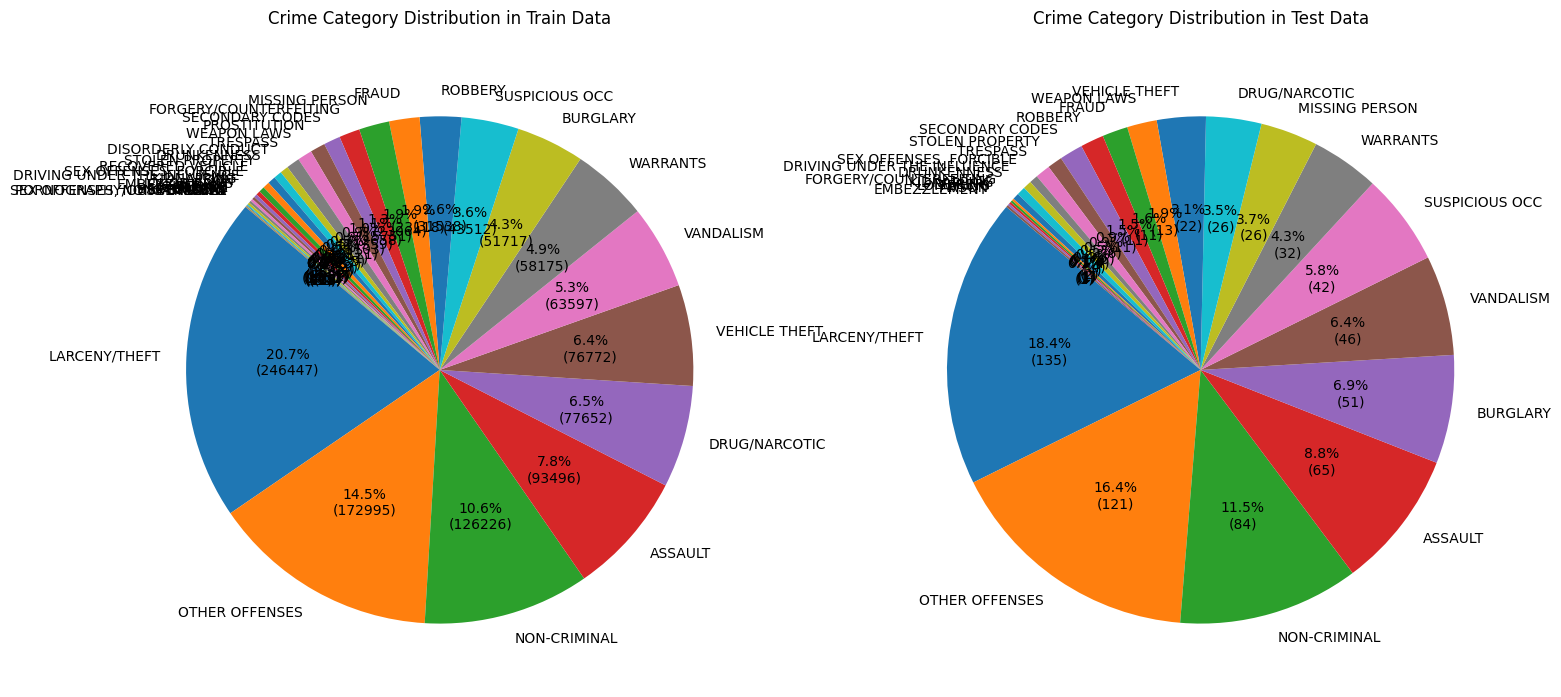

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_df and test_df are your dataframes and they have a column 'Category' for crime types

# Calculate the distribution of crime categories in train_df
train_category_counts = train_df['Category'].value_counts()
train_category_labels = train_category_counts.index
train_category_sizes = train_category_counts.values

# Calculate the distribution of crime categories in test_df
test_category_counts = test_df['Category'].value_counts()
test_category_labels = test_category_counts.index
test_category_sizes = test_category_counts.values

# Function to format the labels
def autopct_format(pct, allvals):
    absolute = int(pct/100.*sum(allvals))
    return f"{pct:.1f}%\n({absolute})"

# Plot pie chart for train_df
plt.figure(figsize=(18, 9))

plt.subplot(1, 2, 1)
plt.pie(train_category_sizes, labels=train_category_labels, autopct=lambda pct: autopct_format(pct, train_category_sizes), startangle=140)
plt.title(f'Crime Category Distribution in Train Data\n')

# Plot pie chart for test_df
plt.subplot(1, 2, 2)
plt.pie(test_category_sizes, labels=test_category_labels, autopct=lambda pct: autopct_format(pct, test_category_sizes), startangle=140)
plt.title(f'Crime Category Distribution in Test Data\n')

plt.show()

##Correlation Heatmap

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

Correlation of features with Category_encoded:
 PdDistrict_TENDERLOIN    0.062211
PdDistrict_INGLESIDE     0.048558
PdDistrict_BAYVIEW       0.033132
year                     0.030754
PdDistrict_TARAVAL       0.027411
PdDistrict_SOUTHERN      0.026940
hour                     0.022336
minute                   0.020237
PdDistrict_CENTRAL       0.018505
PdDistrict_RICHMOND      0.014968
PdDistrict_NORTHERN      0.010740
PdDistrict_PARK          0.006912
PdDistrict_MISSION       0.006062
month                    0.002311
X                        0.002159
Y                        0.002159
day_of_week              0.002066
day                      0.001979
Name: Category_encoded, dtype: float64


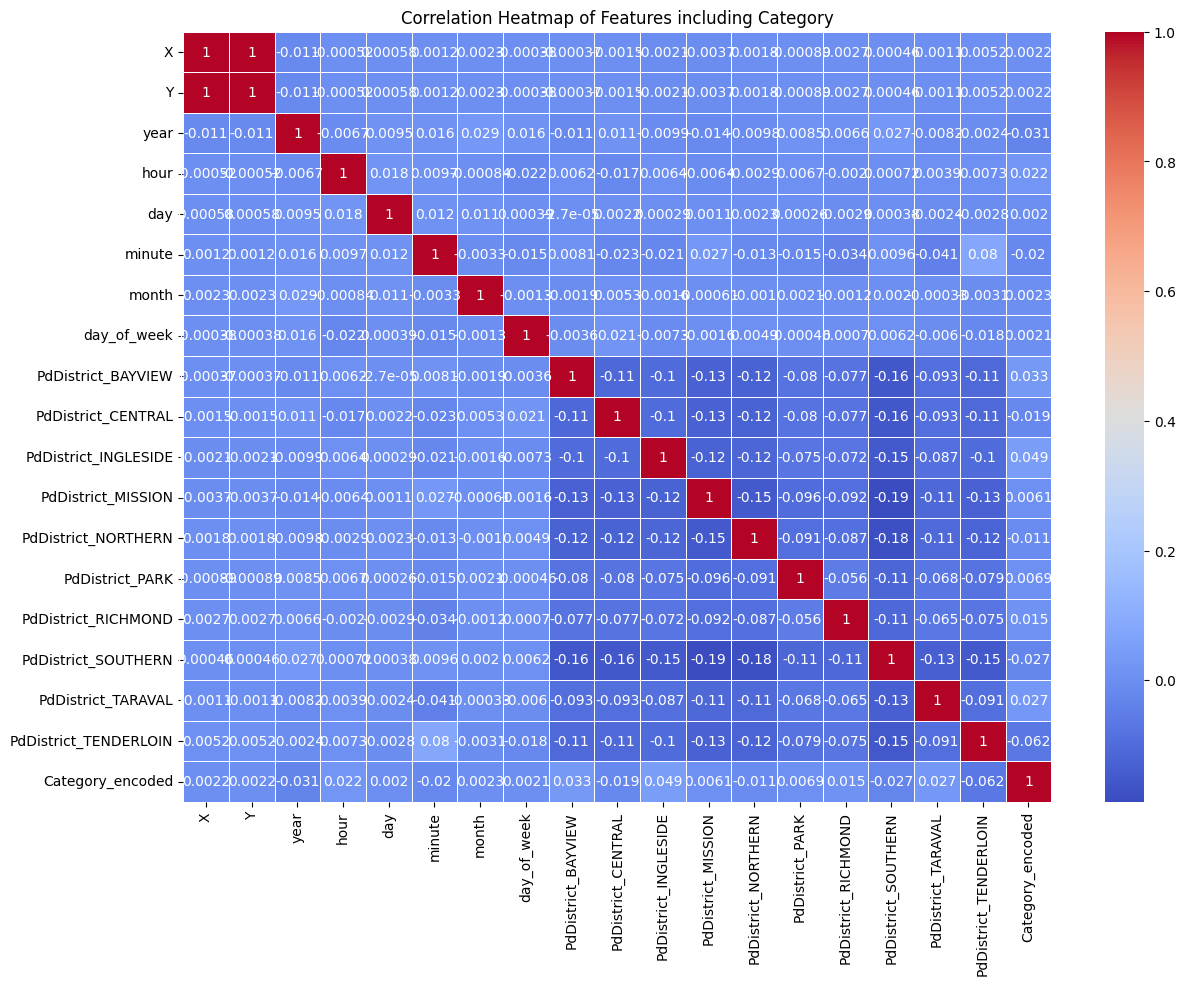

In [ ]:
feature_all=['PdDistrict', 'X', 'Y', 'year', 'hour','day','minute','month','day_of_week']

# Create a dataframe with these features
df_features = sf_crime[feature_all]

# One-hot encode the 'PdDistrict' column
df_features = pd.get_dummies(df_features, columns=['PdDistrict'])

# Convert boolean True/False to 1/0
df_features = df_features.astype(int)

# Check for missing values and handle them if necessary
df_features = df_features.dropna()

# Ensure all features are numeric
assert df_features.applymap(lambda x: isinstance(x, (int, float))).all().all(), "Some features are not numeric."

# Label encode the 'Category' column
label_encoder_category = LabelEncoder()
sf_crime['Category_encoded'] = label_encoder_category.fit_transform(sf_crime['Category'])
# Add 'Category_encoded' to the features
df_features['Category_encoded'] = sf_crime['Category_encoded']

# Compute the correlation matrix
correlation_matrix = df_features.corr()

# Extract the correlation of all features with 'Category_encoded'
category_corr = correlation_matrix['Category_encoded'].drop('Category_encoded')

# Sort correlations by absolute value in descending order
relevant_features = category_corr.abs().sort_values(ascending=False)

print("Correlation of features with Category_encoded:\n", relevant_features)

# Plot the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Features including Category')
plt.show()

#Model Training

In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
label_encoder = LabelEncoder()

# Encode 'Category' (target variable)
train_df['Category'] = label_encoder.fit_transform(train_df['Category'])
test_df['Category'] = label_encoder.transform(test_df['Category'])

<ipython-input-13-9c2db736ad87>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Category'] = label_encoder.fit_transform(train_df['Category'])
<ipython-input-13-9c2db736ad87>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Category'] = label_encoder.transform(test_df['Category'])


In [ ]:
# Define the features and target variable
features = ['PdDistrict','hour','day','minute','day_of_week', 'month', 'X', 'Y']
X_train = train_df[features]
y_train = train_df['Category']
X_test = test_df[features]
y_test = test_df['Category']

# One-hot encode the 'PdDistrict' feature
X_train = pd.get_dummies(X_train, columns=['PdDistrict'])
X_test = pd.get_dummies(X_test, columns=['PdDistrict'])

# Ensure the columns match between train and test sets
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [ ]:
X_train.head()

,hour,day,minute,day_of_week,month,X,Y,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
0,17,22,50,0,11,-122.420084,37.708311,False,False,True,False,False,False,False,False,False,False
1,20,18,0,1,10,-120.500000,90.000000,False,False,False,False,False,True,False,False,False,False
2,2,15,0,6,2,-120.500000,90.000000,False,False,False,False,False,False,False,True,False,False
3,5,18,27,4,2,-122.436220,37.724377,False,False,True,False,False,False,False,False,False,False
4,17,21,0,6,11,-122.410541,37.770913,False,False,False,False,False,False,False,True,False,False


In [ ]:
# Initialize the XGBoost model
model = XGBClassifier(n_estimators=100, max_depth=8, learning_rate=0.6, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# # Print detailed classification report
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, labels=label_encoder.transform(label_encoder.classes_)))

Accuracy: 0.25
Precision: 0.19
Recall: 0.25
F1 Score: 0.19


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Example: Trying a RandomForest
rf_model = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.2f}')

Random Forest Accuracy: 0.25


##Try 2 - XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters
param = {
    'bst:max_depth': 6,
    'objective': 'multi:softprob',
    'num_class': 39,
    'nthread': 6,
    'eval_metric': ['merror', 'mlogloss']
}

# Define evaluation list
evallist = [(dtrain, 'train'), (dtest, 'eval')]

# Number of boosting rounds
num_round = 800

# Train the model
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

# Make predictions
y_pred_probs = bst.predict(dtest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:39:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "bst:max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-merror:0.73197	train-mlogloss:3.07144	eval-merror:0.77778	eval-mlogloss:3.15677
[1]	train-merror:0.72300	train-mlogloss:2.87948	eval-merror:0.76423	eval-mlogloss:2.99117
[2]	train-merror:0.71957	train-mlogloss:2.75761	eval-merror:0.76152	eval-mlogloss:2.88228
[3]	train-merror:0.71756	train-mlogloss:2.66992	eval-merror:0.76287	eval-mlogloss:2.80446
[4]	train-merror:0.71578	train-mlogloss:2.60377	eval-merror:0.75881	eval-mlogloss:2.74556
[5]	train-merror:0.71497	train-mlogloss:2.55388	eval-merror:0.75339	eval-mlogloss:2.69936
[6]	train-merror:0.71272	train-mlogloss:2.51344	eval-merror:0.74661	eval-mlogloss:2.66547
[7]	train-merror:0.71221	train-mlogloss:2.48169	eval-merror:0.74526	eval-mlogloss:2.63874
[8]	train-merror:0.71097	train-mlogloss:2.45525	eval-merror:0.74797	eval-mlogloss:2.61185
[9]	train-merror:0.71020	train-mlogloss:2.43340	eval-merror:0.75068	eval-mlogloss:2.59429
[10]	train-merror:0.70952	train-mlogloss:2.41597	eval-merror:0.75474	eval-mlogloss:2.57902
[11]	trai

##Training a Neural Network

In [ ]:
from sklearn import preprocessing as prepro
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from collections import Counter
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import tensorflow as tf

In [ ]:
# Convert y to categorical (assuming y is numeric)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Preprocessing and Standardize X_train and X_test
X_train = prepro.StandardScaler().fit_transform(X_train)
X_test = prepro.StandardScaler().fit_transform(X_test)

# Convert y_train to a NumPy array of floating-point values
y_train_float = y_train.astype(np.float32)

# Convert y_train to a Tensor
y_train_tensor = tf.convert_to_tensor(y_train_float)

Epoch 1/100
2195/2195 [==============================] - 9s 3ms/step - loss: 2.6819 - accuracy: 0.2224 - val_loss: 2.6095 - val_accuracy: 0.2100
Epoch 2/100
2195/2195 [==============================] - 8s 4ms/step - loss: 2.5360 - accuracy: 0.2410 - val_loss: 2.6089 - val_accuracy: 0.2182
Epoch 3/100
2195/2195 [==============================] - 7s 3ms/step - loss: 2.5129 - accuracy: 0.2468 - val_loss: 2.6369 - val_accuracy: 0.2331
Epoch 4/100
2195/2195 [==============================] - 8s 4ms/step - loss: 2.4951 - accuracy: 0.2505 - val_loss: 2.6604 - val_accuracy: 0.2209
Epoch 5/100
2195/2195 [==============================] - 6s 3ms/step - loss: 2.4854 - accuracy: 0.2540 - val_loss: 2.7973 - val_accuracy: 0.1938
Epoch 6/100
2195/2195 [==============================] - 10s 5ms/step - loss: 2.4796 - accuracy: 0.2553 - val_loss: 3.1871 - val_accuracy: 0.1856
Epoch 7/100
2195/2195 [==============================] - 6s 3ms/step - loss: 2.4679 - accuracy: 0.2581 - val_loss: 3.6785 - val_a

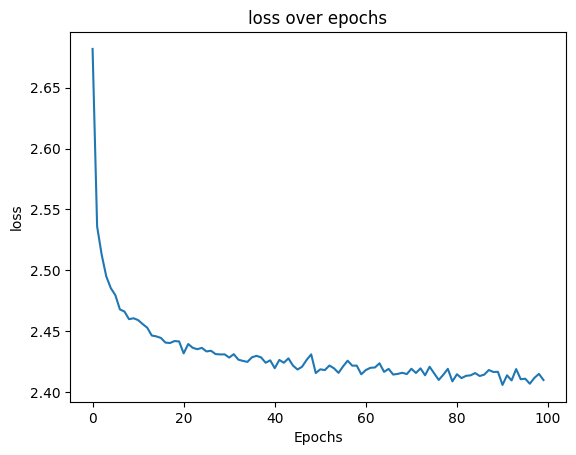

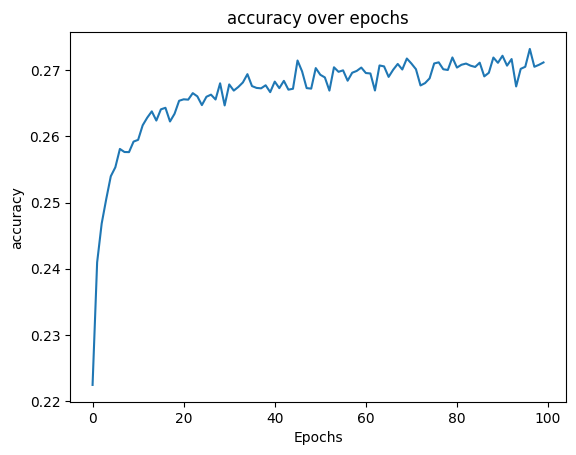

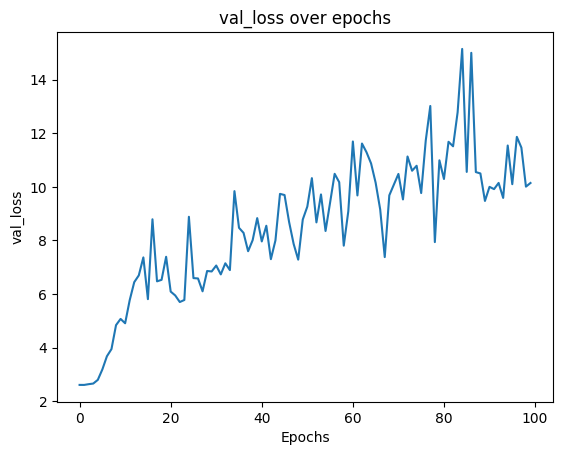

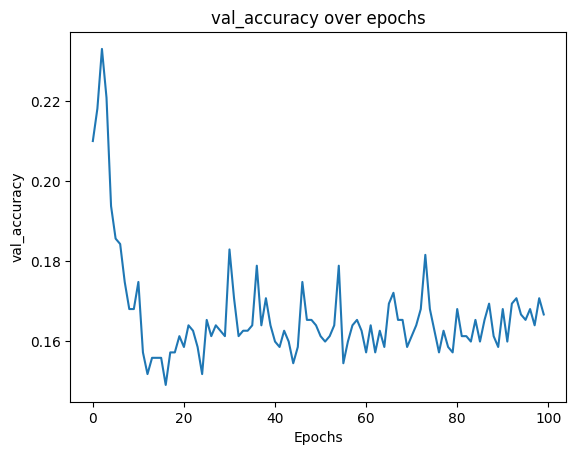

In [ ]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')

# Ensure that y_train_categorical and y_test_categorical are numpy arrays
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Convert y_train to a Tensor
y_train_tensor = tf.convert_to_tensor(y_train_categorical)

# Train the model
history = model.fit(X_train, y_train_tensor, validation_data=(X_test, y_test_categorical), batch_size=64, epochs=100, steps_per_epoch=2195)

for j in list(history.history.keys()):
    plt.plot(history.history[j])
    plt.title(j + ' over epochs')
    plt.ylabel(j)
    plt.xlabel('Epochs')
    plt.show()

##Transforming Time into Cyclic Representations

###XGBoost

<ipython-input-24-813132f363e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
<ipython-input-24-813132f363e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
<ipython-input-24-813132f363e1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Accuracy: 0.23035230352303523


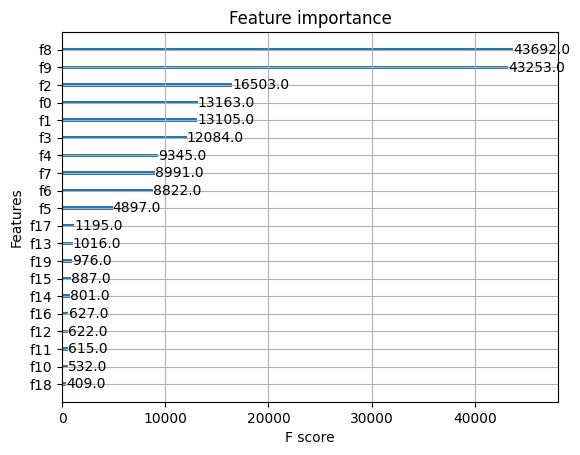

In [ ]:
# Define a function to transform time features into cyclic representations
def transform_cyclic_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  # Assuming day of month ranges from 1 to 31
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

# Apply the transformation to both training and test datasets
train_df = transform_cyclic_features(train_df)
test_df = transform_cyclic_features(test_df)

# Select features and labels
features = ['PdDistrict', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'X', 'Y']
X_train = train_df[features]
y_train = train_df['Category']
X_test = test_df[features]
y_test = test_df['Category']

# Convert categorical features to numeric using one-hot encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Ensure both train and test sets have the same dummy variables
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the XGBoost model
model = xgb.XGBClassifier(objective='multi:softprob', num_class=39, eval_metric='mlogloss', use_label_encoder=False)

# Train the model
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Plotting feature importances
xgb.plot_importance(model)
plt.show()

##Neural Network

In [ ]:
# Define a function to transform time features into cyclic representations
def transform_cyclic_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  # Assuming day of month ranges from 1 to 31
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

# Apply the transformation to both training and test datasets
train_df = transform_cyclic_features(train_df)
test_df = transform_cyclic_features(test_df)

# Select features and labels
features = ['PdDistrict', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'X', 'Y']
X_train = train_df[features]
y_train = train_df['Category']
X_test = test_df[features]
y_test = test_df['Category']

# Convert categorical features to numeric using one-hot encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Ensure both train and test sets have the same dummy variables
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

<ipython-input-25-f2a4fde4e23c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
<ipython-input-25-f2a4fde4e23c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
<ipython-input-25-f2a4fde4e23c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [ ]:
# Convert y to categorical (assuming y is numeric)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Preprocessing and Standardize X_train and X_test
X_train = prepro.StandardScaler().fit_transform(X_train)
X_test = prepro.StandardScaler().fit_transform(X_test)

# Convert y_train to a NumPy array of floating-point values
y_train_float = y_train.astype(np.float32)

# Convert y_train to a Tensor
y_train_tensor = tf.convert_to_tensor(y_train_float)

Epoch 1/100
2195/2195 [==============================] - 10s 4ms/step - loss: 2.7215 - accuracy: 0.2107 - val_loss: 2.6348 - val_accuracy: 0.2019
Epoch 2/100
2195/2195 [==============================] - 6s 3ms/step - loss: 2.5712 - accuracy: 0.2293 - val_loss: 2.6249 - val_accuracy: 0.2100
Epoch 3/100
2195/2195 [==============================] - 8s 4ms/step - loss: 2.5570 - accuracy: 0.2323 - val_loss: 2.6164 - val_accuracy: 0.2222
Epoch 4/100
2195/2195 [==============================] - 6s 3ms/step - loss: 2.5438 - accuracy: 0.2376 - val_loss: 2.6576 - val_accuracy: 0.2209
Epoch 5/100
2195/2195 [==============================] - 8s 4ms/step - loss: 2.5352 - accuracy: 0.2401 - val_loss: 2.9579 - val_accuracy: 0.1965
Epoch 6/100
2195/2195 [==============================] - 6s 3ms/step - loss: 2.5375 - accuracy: 0.2396 - val_loss: 3.6549 - val_accuracy: 0.1680
Epoch 7/100
2195/2195 [==============================] - 8s 4ms/step - loss: 2.5299 - accuracy: 0.2412 - val_loss: 3.7317 - val_a

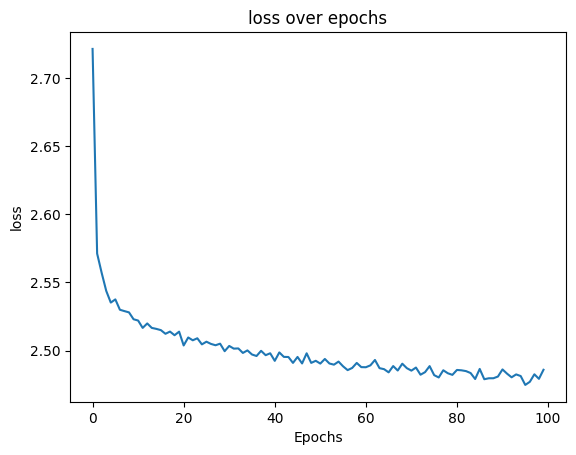

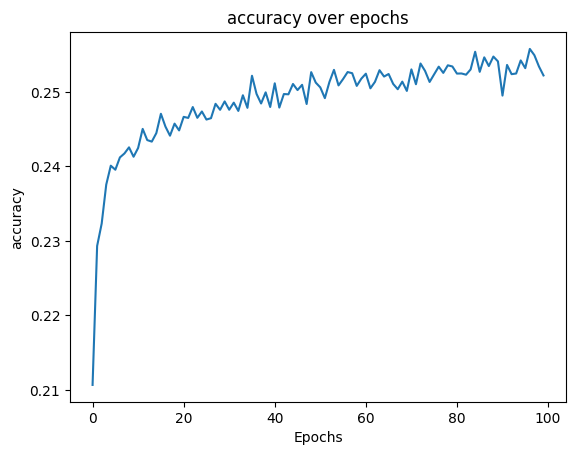

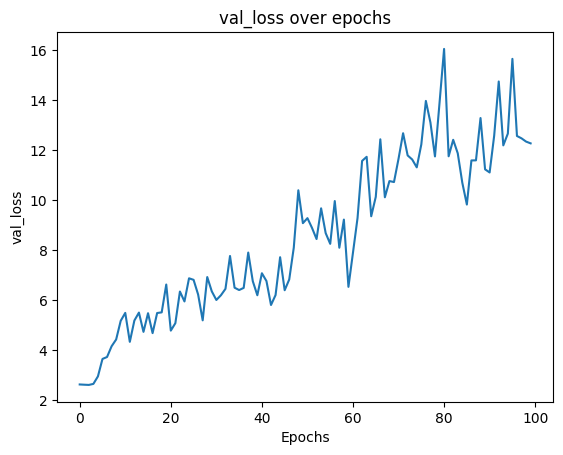

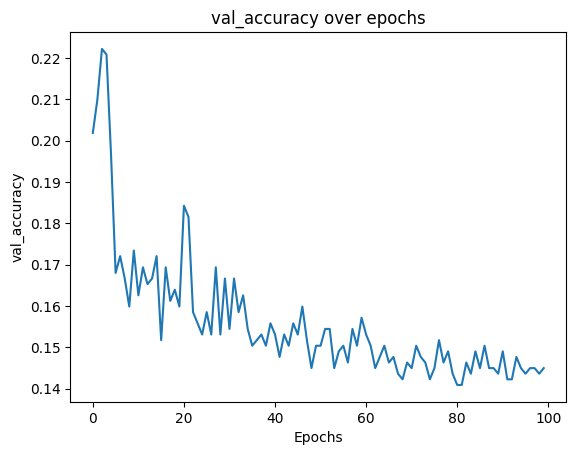

In [ ]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')

# Ensure that y_train_categorical and y_test_categorical are numpy arrays
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Convert y_train to a Tensor
y_train_tensor = tf.convert_to_tensor(y_train_categorical)

# Train the model
history = model.fit(X_train, y_train_tensor, validation_data=(X_test, y_test_categorical), batch_size=64, epochs=100, steps_per_epoch=2195)

for j in list(history.history.keys()):
    plt.plot(history.history[j])
    plt.title(j + ' over epochs')
    plt.ylabel(j)
    plt.xlabel('Epochs')
    plt.show()

##ST-ResNet

###1. Data Preparation
preprocess the data to fit it into a spatio-temporal grid.

In [ ]:
import numpy as np
import pandas as pd

# Define the grid size (e.g., 100x100 grid for the city)
GRID_SIZE = 50

# Define the bounding box for the city (these are just example coordinates)
lat_min, lat_max = train_df['Y'].min(), train_df['Y'].max()
lon_min, lon_max = train_df['X'].min(), train_df['X'].max()

# Calculate the grid cell size
lat_step = (lat_max - lat_min) / GRID_SIZE
lon_step = (lon_max - lon_min) / GRID_SIZE

# Function to map coordinates to grid
def map_to_grid(x, y):
    grid_x = int((x - lon_min) / lon_step)
    grid_y = int((y - lat_min) / lat_step)
    grid_x = min(max(grid_x, 0), GRID_SIZE - 1)  # Ensure grid_x is within bounds
    grid_y = min(max(grid_y, 0), GRID_SIZE - 1)  # Ensure grid_y is within bounds
    return grid_x, grid_y

# Apply the mapping function to get grid coordinates
train_df['grid_x'], train_df['grid_y'] = zip(*train_df.apply(lambda row: map_to_grid(row['X'], row['Y']), axis=1))
test_df['grid_x'], test_df['grid_y'] = zip(*test_df.apply(lambda row: map_to_grid(row['X'], row['Y']), axis=1))

# Create the spatio-temporal grid for training
time_intervals = 24 * 7  # One week with hourly intervals
num_categories = train_df['Category'].nunique()

# Create a dictionary to map categories to integers
category_map = {category: idx for idx, category in enumerate(train_df['Category'].unique())}

# Initialize the grid
spatial_grid_train = np.zeros((GRID_SIZE, GRID_SIZE, time_intervals, num_categories))
spatial_grid_test = np.zeros((GRID_SIZE, GRID_SIZE, time_intervals, num_categories))

# Populate the training grid
for _, row in train_df.iterrows():
    time_index = row['hour'] + (row['day_of_week'] * 24)
    spatial_grid_train[row['grid_x'], row['grid_y'], time_index, category_map[row['Category']]] += 1

# Populate the test grid
for _, row in test_df.iterrows():
    time_index = row['hour'] + (row['day_of_week'] * 24)
    spatial_grid_test[row['grid_x'], row['grid_y'], time_index, category_map[row['Category']]] += 1

<ipython-input-28-fcbfc97bb24e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['grid_x'], train_df['grid_y'] = zip(*train_df.apply(lambda row: map_to_grid(row['X'], row['Y']), axis=1))
<ipython-input-28-fcbfc97bb24e>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['grid_x'], train_df['grid_y'] = zip(*train_df.apply(lambda row: map_to_grid(row['X'], row['Y']), axis=1))
<ipython-input-28-fcbfc97bb24e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

###2. Model Training
Build and train the ST-ResNet model using a deep learning framework like TensorFlow/Keras.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

def build_st_resnet(grid_size, time_intervals, num_classes):
    input_layer = layers.Input(shape=(grid_size, grid_size, time_intervals, num_classes))

    # Define residual blocks (simplified example)
    x = layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu')(input_layer)
    x = layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.Conv3D(num_classes, (3, 3, 3), padding='same', activation='relu')(x)

    # Global average pooling
    x = layers.GlobalAveragePooling3D()(x)

    # Output layer
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define parameters
GRID_SIZE = 50
time_intervals = 168
num_classes = 39

spatial_grid_train = np.random.rand(GRID_SIZE, GRID_SIZE, time_intervals, num_classes)
spatial_grid_test = np.random.rand(GRID_SIZE, GRID_SIZE, time_intervals, num_classes)

# Check the shape of spatial_grid_train and spatial_grid_test
print(f"spatial_grid_train shape: {spatial_grid_train.shape}")
print(f"spatial_grid_test shape: {spatial_grid_test.shape}")

# Reshape the data for the model input
X_train = spatial_grid_train.reshape((-1, GRID_SIZE, GRID_SIZE, time_intervals, num_classes))
X_test = spatial_grid_test.reshape((-1, GRID_SIZE, GRID_SIZE, time_intervals, num_classes))

# Generate labels for training and testing (one-hot encoded)
y_train = np.zeros((X_train.shape[0], num_classes))
y_test = np.zeros((X_test.shape[0], num_classes))

# Build and compile the model
model = build_st_resnet(GRID_SIZE, time_intervals, num_classes)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print(f'Accuracy: {accuracy:.2f}')

spatial_grid_train shape: (50, 50, 168, 39)
spatial_grid_test shape: (50, 50, 168, 39)
Epoch 1/10
1/1 [==============================] - 32s 32s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 24s 24s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 22s 22s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 24s 24s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 22s 22s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 22s 22s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 23s 23s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 23s 23s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 24s 24s/step - loss: 0.